# Semantic Segmentation with UNets in PyTorch

U-Net 기반 세그멘테이션

* U-Net이라 불리는 인코더(다운샘플링)와 디코더(업샘플링)를 포함한 구조

* Encoder-decoder 구조 또한 semantic segmentation을 위한 CNN 구조로 자주 활용

* Encoder 부분에서는 점진적으로 spatial dimension을 줄여가면서 고차원의 semantic 정보를 convolution filter가 추출해낼 수 있게 함

* Decoder 부분에서는 encoder에서 spatial dimension 축소로 인해 손실된 spatial 정보를 점진적으로 복원하여 보다 정교한 boundary segmentation을 완성

* U-Net은 기본적인 encoder-decoder 구조와 달리 Spatial 정보를 복원하는 과정에서 이전 encoder feature map 중 동일한 크기를 지닌 feature map을 가져 와 prior로 활용함으로써 더 정확한 boundary segmentation이 가능하게 함

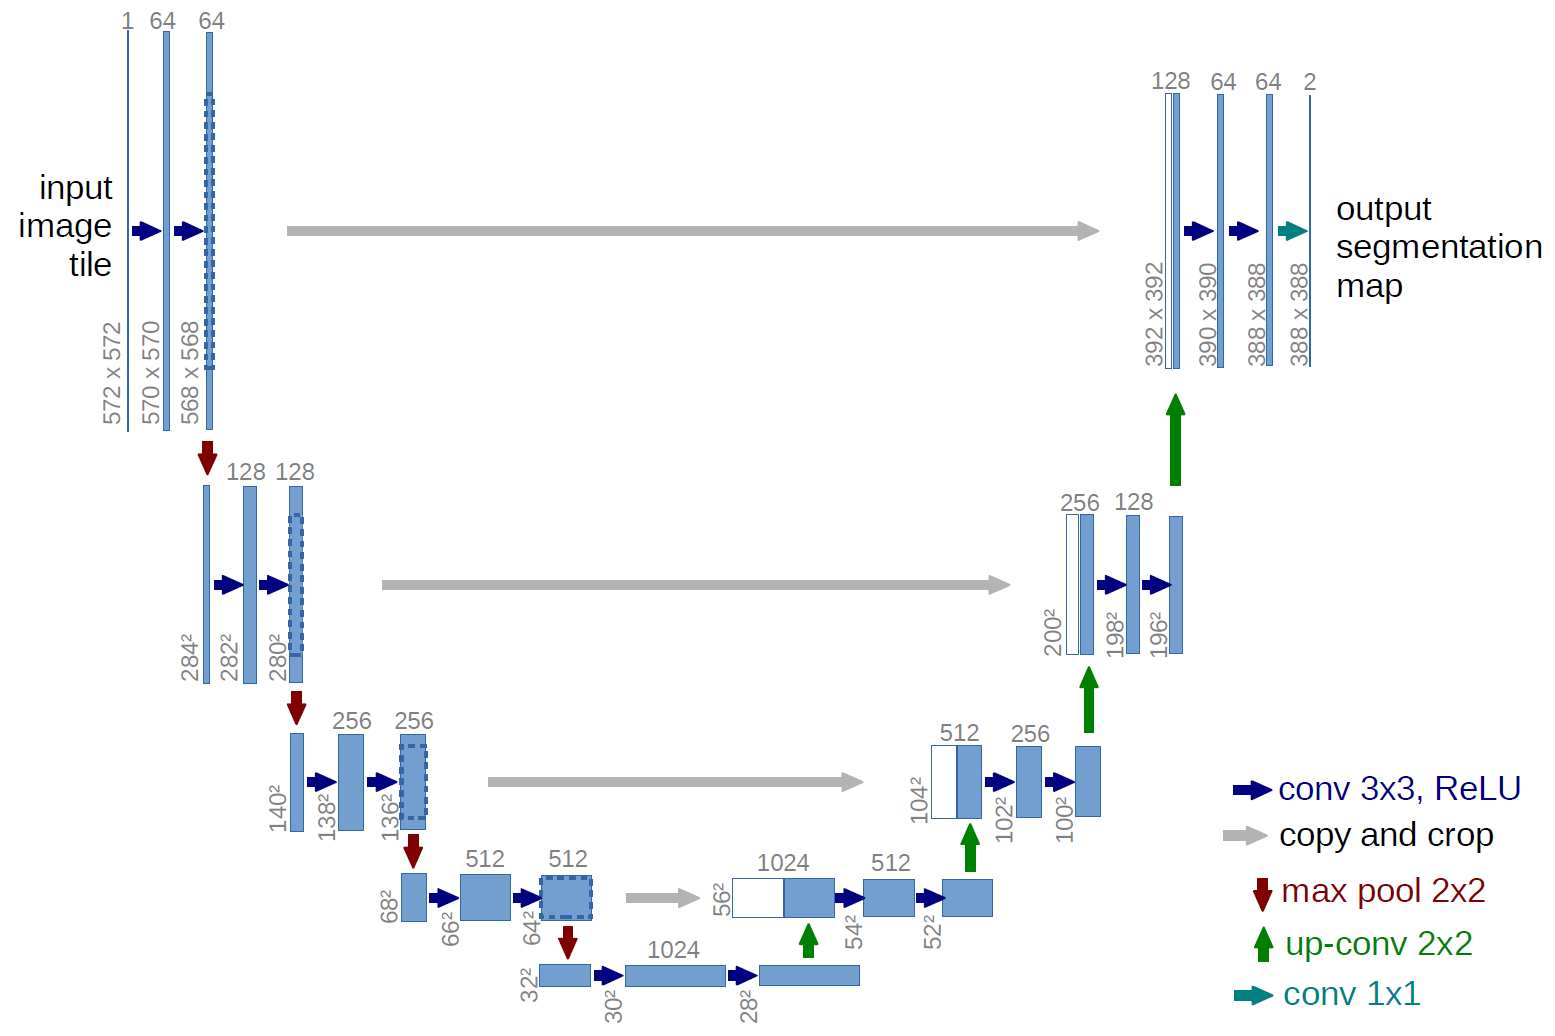

In [1]:
import os
import numpy as np
import random 
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from torchvision.io import read_image
from torchvision.transforms import ToPILImage
import torchvision.transforms as transforms


/home/e1_u2/.conda/envs/sandbox/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/e1_u2/.conda/envs/sandbox/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZNK3c1010TensorImpl36is_contiguous_nondefault_policy_implENS_12MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# 데이터 다운로드 

!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz 
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

--2023-10-27 16:58:55--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz [following]
--2023-10-27 16:58:56--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz [following]
--2023-10-27 16:58:57--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 301 Moved Perman

In [2]:
# 이미지 파일 경로 설정 

input_dir = "images/"
target_dir = "annotations/trimaps/" 

input_img_paths = sorted(
    [os.path.join(input_dir, fname) 
for fname in os.listdir(input_dir) 
if fname.endswith(".jpg")])

target_paths = sorted(
    [os.path.join(target_dir, fname) 
for fname in os.listdir(target_dir)
if fname.endswith(".png") and not fname.startswith(".")])

(1, 400, 600, 3)


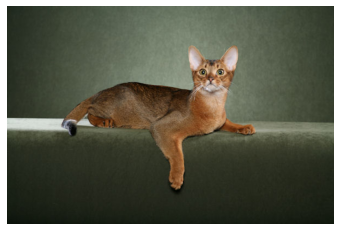

(1, 473, 600, 3)


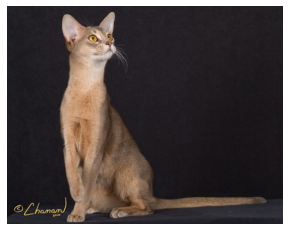

(1, 869, 600, 3)


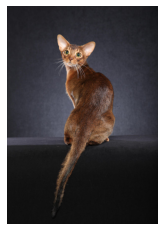

(1, 500, 335, 3)


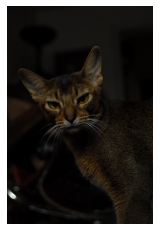

(1, 150, 200, 4)


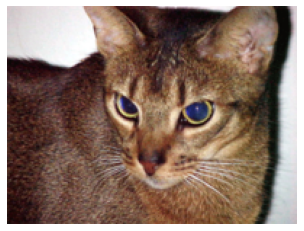

In [3]:
# 데이터 시각화 해보기
# 5개의 이미지를 불러와서 시각화 해보기

for i in range(5):

    img_path = f'./images/Abyssinian_{i+1}.jpg'
    img = Image.open(img_path)

    img_tensor = np.array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)

    print(img_tensor.shape)
    plt.axis("off")
    plt.imshow(img_tensor[0])
    plt.show()

(200, 200)
(200, 200, 3)
(1, 200, 200, 3)


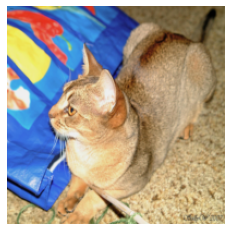

(1, 200, 200, 3)


In [4]:
img_path = './images/'
img = Image.open(input_img_paths[9])

desired_size = (200, 200)
resize = transforms.Resize(desired_size)
resized_image = resize(img)
print(resized_image.size)

img_tensor = np.array(resized_image)
print(img_tensor.shape)
img_tensor = np.expand_dims(img_tensor, axis=0)
print(img_tensor.shape)


plt.axis("off")
plt.imshow(img_tensor[0])
plt.show()

print(img_tensor.shape)


(1, 200, 200, 1)


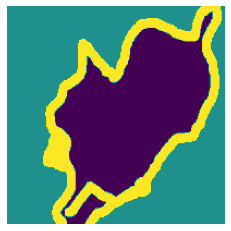

In [5]:
def display_target(target_array):
    normalized_array = (target_array.astype("uint8") - 1) * 127 
    plt.axis("off")
    plt.imshow(normalized_array[0, :, :])

img = Image.open(target_paths[9])

desired_size = (200, 200)
resize = transforms.Resize(desired_size)
resized_image = resize(img)

img = np.expand_dims(np.array(resized_image), axis=0)
img = img.reshape((1, 200, 200, 1))

display_target(img)

print(img.shape)

In [6]:
# Load inputs and targets in to NumPy arrays and split in to training and validation set

img_size = (200, 200)
num_imgs = len(input_img_paths)  # number of images in dataset

random.Random(1337).shuffle(input_img_paths) # 랜덤하게 섞어줌
random.Random(1337).shuffle(target_paths) 


def path_to_input_image(path):
    
    resize = transforms.Resize(img_size)
    resized_image = resize(Image.open(path))
    img = np.expand_dims(np.array(resized_image), axis=0) 
    
    try:
        img = img[:, :, :, :3] # 이미지 데이터의 형태가 (1, 200, 200, 4)의 경우는 한 채널을 줄임

    except:
        img = img.reshape((1, 200, 200, 1)) # 이미지 데이터의 형태가 (1, 200, 200)의 경우는 차원을 늘림
        img = np.concatenate((img, img, img), axis=-1) # 그 다음 3겹으로 쌓아 차원을 맞춰줌
    
    return img

def path_to_target(path):
    
    resize = transforms.Resize(img_size)
    resized_image = resize(Image.open(path))    
    img = np.expand_dims(np.array(resized_image), axis=0) 
    img = img.reshape((1, 200, 200, 1))
    img = img.astype("uint8") - 1 
    return img

input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32") 
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8") 
print(targets.shape)

for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i]) 
    targets[i] = path_to_target(target_paths[i])


num_val_samples = 1000
train_input_imgs = input_imgs[:-num_val_samples] 
train_targets = targets[:-num_val_samples] 
val_input_imgs = input_imgs[-num_val_samples:] 
val_targets = targets[-num_val_samples:]

(7390, 200, 200, 1)


In [9]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        factor = 2 if bilinear else 1
        self.down3 = (Down(256, 512 // factor))
        self.up1 = (Up(512, 256 // factor, bilinear))
        self.up2 = (Up(256, 128 // factor, bilinear))
        self.up3 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x = self.up1(x4, x3)
        x = self.up2(x, x2)
        x = self.up3(x, x1)
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.outc = torch.utils.checkpoint(self.outc)
        
        
# 모델 정의하기 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

net = UNet(3,3).to(device)
print(net)

cuda
UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fal

In [18]:
# Network Training

# 하이퍼 파라미터 설정
lr = 0.001
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
critereon = nn.CrossEntropyLoss()

epochs = 1

for epoch in range(epochs):
    net.train()
    running_loss = 0.0

    for i, data in enumerate(zip(train_input_imgs, train_targets)):
        inputs, labels = data
        inputs = inputs.reshape((1, 200, 200, 3))
        inputs = inputs.transpose(0, 3, 1, 2) # shape : (1, 3, 200, 200)
        inputs = torch.from_numpy(inputs).float().to(device)
        
        labels = labels.reshape((1, 200, 200, 1))
        labels = labels.transpose(0, 3, 1, 2) # shape : (1, 1, 200, 200)
        labels = torch.from_numpy(labels).float().to(device)
        labels = torch.cat([labels] * 3, dim=1)
        
        optimizer.zero_grad()

        outputs = net(inputs)       
        loss = critereon(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 5 == 0:
            print('[%d, %5d] loss: %.3f' % (epoch+1, i+1, running_loss/100))
            running_loss = 0.0

[1,     1] loss: 0.022
[1,     6] loss: 0.142
[1,    11] loss: 0.151
[1,    16] loss: 0.135
[1,    21] loss: 0.134
[1,    26] loss: 0.130
[1,    31] loss: 0.149
[1,    36] loss: 0.131
[1,    41] loss: 0.120
[1,    46] loss: 0.137
[1,    51] loss: 0.141
[1,    56] loss: 0.146
[1,    61] loss: 0.142
[1,    66] loss: 0.120
[1,    71] loss: 0.149
[1,    76] loss: 0.131
[1,    81] loss: 0.129
[1,    86] loss: 0.126
[1,    91] loss: 0.142
[1,    96] loss: 0.124
[1,   101] loss: 0.143
[1,   106] loss: 0.145
[1,   111] loss: 0.157
[1,   116] loss: 0.142
[1,   121] loss: 0.141
[1,   126] loss: 0.145
[1,   131] loss: 0.138
[1,   136] loss: 0.127
[1,   141] loss: 0.152
[1,   146] loss: 0.151
[1,   151] loss: 0.136
[1,   156] loss: 0.143
[1,   161] loss: 0.138
[1,   166] loss: 0.132
[1,   171] loss: 0.111
[1,   176] loss: 0.128
[1,   181] loss: 0.132
[1,   186] loss: 0.144
[1,   191] loss: 0.135
[1,   196] loss: 0.147
[1,   201] loss: 0.150
[1,   206] loss: 0.133
[1,   211] loss: 0.140
[1,   216] 

# Inference

[[[148 157 169]
  [150 160 172]
  [148 158 170]
  ...
  [128 141 149]
  [129 140 149]
  [127 138 147]]

 [[148 158 170]
  [150 159 171]
  [149 159 169]
  ...
  [128 141 149]
  [127 140 148]
  [125 139 147]]

 [[144 154 166]
  [148 158 169]
  [140 149 159]
  ...
  [126 141 148]
  [125 140 147]
  [123 138 145]]

 ...

 [[128 129 140]
  [132 131 144]
  [130 130 145]
  ...
  [139 140 146]
  [135 133 135]
  [126 123 121]]

 [[144 143 153]
  [146 144 155]
  [146 145 156]
  ...
  [129 128 126]
  [121 120 116]
  [114 113 109]]

 [[166 162 170]
  [163 162 169]
  [164 161 167]
  ...
  [130 129 133]
  [130 127 133]
  [133 128 136]]]
(200, 200, 3)


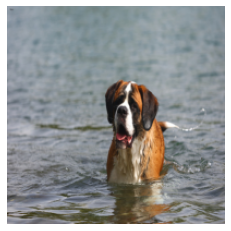

In [34]:
test_image = val_input_imgs.astype("int")[0]
print(test_image.view())
print(test_image.shape)

plt.axis("off")
plt.imshow(test_image)
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 200, 200, 3)
torch.Size([1, 3, 200, 200])
[[[[0.05106979 0.05127738 0.05068973 ... 0.05082086 0.05101705
    0.05086384]
   [0.05107465 0.05184353 0.04970393 ... 0.05043503 0.05058257
    0.04985506]
   [0.04965935 0.04879159 0.04961242 ... 0.04897876 0.05047829
    0.05149177]
   ...
   [0.04981656 0.04998562 0.04948848 ... 0.05007651 0.05080653
    0.05071035]
   [0.04990763 0.04937165 0.04991366 ... 0.05027374 0.05110593
    0.05111092]
   [0.04980058 0.04822204 0.05100308 ... 0.05025778 0.05139089
    0.05239168]]

  [[0.05113279 0.05163012 0.05089802 ... 0.0509564  0.05113988
    0.0507713 ]
   [0.05127139 0.05208553 0.05025265 ... 0.05072716 0.05080634
    0.05000821]
   [0.04996933 0.04933372 0.0503011  ... 0.04954567 0.05082374
    0.05158263]
   ...
   [0.05018533 0.05056964 0.05027787 ... 0.05059081 0.05109344
    0.05084392]
   [0.05019551 0.04960985 0.0504751  ... 0.05061813 0.0512549
    0.05135454]
   [0.04992359 0.0485619  0.05120017 ... 0.05046936 0.05142132
    0.0

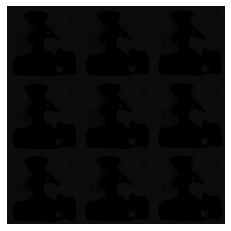

In [57]:
net.eval()

with torch.no_grad():
    test_image = val_input_imgs.astype("int")[0]
    test_image = test_image.reshape((1, 200, 200, 3))
    print(test_image.shape)
    test_image = test_image.transpose(0, 3, 1, 2) # shape : (1, 3, 200, 200)
    test_image = torch.from_numpy(test_image).float().to(device)
    
    outputs = net(test_image)
    print(outputs.shape)

result = outputs.cpu().detach().numpy()
print(result.view())
# result의 값이 0~255의 정수값을 가져야 하는데 0~1 사이의 실수값을 가지고 있음

result = result * 255
print(result.view())

result = result.reshape((200, 200, 3))
result = result.astype("int")

plt.axis("off") 
plt.imshow(result)
plt.show()


U-net이 꾀 무거운 편이어서 layer의 깊이도 Original version 보다 낮추고 진행했다.
또한, 1 epoch에 걸린 시간이 GPU를 사용해도 15분이 걸렸다. 그래서 에폭을 한 번만 하고 매우 낮췄다.
결과적으로 학습이 잘 일어나지 않는 것 같다. 

제대로 된 학습을 하려면 output의 size가 왜 integer의 형태가 아닌지 해석하고 epoch 10이상 까지는 올려봐야 할 것 같다. 하지만 그러면 오늘안에 제출을 못할 것 같다. 


# 성능 끌어올리기 

* 아키텍처 선택 : 이에는 U-Net, SegNet, Mask R-CNN 및 DeepLab 등이 포함
* 데이터 증강 (Data Augmentation) : 데이터 증강 기술을 사용하여 훈련 데이터를 확장할 수 있다. 회전, 반전, 크롭 등의 변환을 적용하여 모델의 일반화 성능을 향상
* 손실 함수 : 세그멘테이션 문제에는 Dice Loss, Cross-Entropy Loss 등이 사용될 수 있다.
* 앙상블 및 후처리 : 여러 모델의 예측을 앙상블하거나 후처리 단계를 추가하여 결과를 향상

# References

https://github.com/milesial/Pytorch-UNet/tree/master